# OpenStreetMap

In [17]:
# packed code:
# pip install overpy
# pip install geopandas

## Part 1: Using Overpass API to query OpenStreetMap 



#### Collects schools, restaurants, hospitals, and malls, retrieves their nodes, ways, and relations, and organizes the data into dictionaries with names and coordinates (longitude, latitude)

In [20]:
# Import packages
import overpy
import warnings
import csv
import geopandas as gpd
import pandas as pd

In [21]:
warnings.filterwarnings('ignore')

# Initialize Overpass API
api = overpy.Overpass()

# Define the bounding box for Denmark (latitude, longitude)
bbox = (54.5, 8.0, 57.9, 15.2)

# Function to query OSM data and extract centroids
def query_osm(tag, value, bbox):
    result = api.query(f"""
    [out:json];
    (
      node["{tag}"="{value}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
      way["{tag}"="{value}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
      relation["{tag}"="{value}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
    );
    (._;>;);
    out body;
    """)

    centroids = {}

    # Extract nodes (direct locations)
    for item in result.nodes:
        name = item.tags.get('name', 'n/a')
        location = (item.lon, item.lat)
        centroids[name] = location

    # Extract centroids for ways (average of all node locations)
    for way in result.ways:
        name = way.tags.get('name', 'n/a')
        if way.nodes:
            lons = [node.lon for node in way.nodes]
            lats = [node.lat for node in way.nodes]
            centroid = (sum(lons) / len(lons), sum(lats) / len(lats))
            centroids[name] = centroid

    # Extract centroids for relations (average of way centroids)
    for relation in result.relations:
        name = relation.tags.get('name', 'n/a')
        relation_centroids = []
        for member in relation.members:
            if isinstance(member, overpy.RelationWay):
                way = next((w for w in result.ways if w.id == member.ref), None)
                if way and way.nodes:
                    lons = [node.lon for node in way.nodes]
                    lats = [node.lat for node in way.nodes]
                    centroid = (sum(lons) / len(lons), sum(lats) / len(lats))
                    relation_centroids.append(centroid)
        if relation_centroids:
            avg_lon = sum(c[0] for c in relation_centroids) / len(relation_centroids)
            avg_lat = sum(c[1] for c in relation_centroids) / len(relation_centroids)
            centroids[name] = (avg_lon, avg_lat)

    return centroids

# Query OSM for different types of locations
schools_centroids = query_osm("amenity", "school", bbox)
restaurants_centroids = query_osm("amenity", "restaurant", bbox)
hospitals_centroids = query_osm("amenity", "hospital", bbox)
malls_centroids = query_osm("shop", "mall", bbox)

# Combine all centroids into a dictionary
all_centroids = {
    "Schools": schools_centroids,
    "Restaurants": restaurants_centroids,
    "Hospitals": hospitals_centroids,
    "Malls": malls_centroids
}

# Write data to CSV with UTF-8 encoding
with open("CSV files/all_centroids.csv", "w", newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["Type", "Name", "Latitude", "Longitude"])
    
    for category, centroids in all_centroids.items():
        for name, location in centroids.items():
            writer.writerow([category, name, location[1], location[0]])  # Lat and Long swapped to match your preference.

print("Data written to 'CSV files/all_centroids.csv'")


Data written to 'CSV files/all_centroids.csv'


5127 data points were outside Denmark and have been removed.


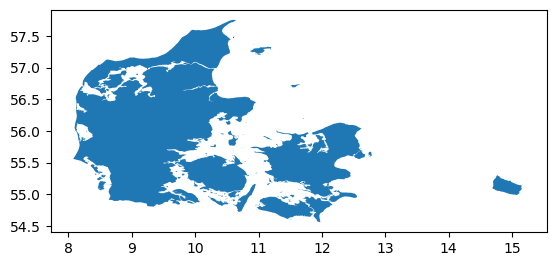

In [22]:
# Load the Denmark boundary shapefile
denmark_boundary = gpd.read_file("Data used/DNK_adm0.shp")

# Plot Denmark boundary
denmark_boundary.plot()

# Load the CSV data
geo_df = pd.read_csv('CSV files/all_centroids.csv')

# Convert the DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(geo_df.Longitude, geo_df.Latitude)
gdf_geo = gpd.GeoDataFrame(geo_df, geometry=geometry)

# Perform a spatial join to identify points within Denmark's boundary
geospatial_inside_denmark = gpd.sjoin(gdf_geo, denmark_boundary, predicate="within")

# Save the filtered data back to a new CSV
geospatial_inside_denmark.drop(columns=['geometry', 'index_right']).to_csv('CSV files/geospatial_inside_denmark.csv', index=False)

print(f"{len(geo_df) - len(geospatial_inside_denmark)} data points were outside Denmark and have been removed.")


 ### Part 2: Public Transportation

In [24]:
api = overpy.Overpass()

# Query for public transport stations in Denmark using the bounding box
result = api.query("""
[out:json];
(
  node["public_transport"="station"](54.5,8.0,57.9,15.2);
  way["public_transport"="station"](54.5,8.0,57.9,15.2);
  relation["public_transport"="station"](54.5,8.0,57.9,15.2);
);
(._;>;);
out body;
""")

# Structure the data
nodes = [{'name': station.tags.get('name', 'n/a'), 'location': (station.lon, station.lat)} for station in result.nodes]
ways = [{'name': way.tags.get('name', 'n/a'), 'nodes': [(node.lon, node.lat) for node in way.nodes]} for way in result.ways]

# For relations, fetch associated ways from the result
relations = []
for relation in result.relations:
    relation_ways = [way for way in result.ways if way.id in [member.ref for member in relation.members if isinstance(member, overpy.RelationWay)]]
    relations.append({'name': relation.tags.get('name', 'n/a'), 'ways': relation_ways})

def get_centroid(nodes):
    """Calculate the centroid of a list of nodes."""
    if not nodes:
        return None
    x_coords = [node[0] for node in nodes]
    y_coords = [node[1] for node in nodes]
    centroid_x = sum(x_coords) / len(nodes)
    centroid_y = sum(y_coords) / len(nodes)
    return (centroid_x, centroid_y)

stations_centroids = {}

# Handle nodes:
for node in nodes:
    station_name = node['name']
    if station_name not in stations_centroids:
        stations_centroids[station_name] = node['location']

# Handle ways:
for way in ways:
    station_name = way['name']
    if station_name not in stations_centroids:
        centroid = get_centroid(way['nodes'])
        if centroid:
            stations_centroids[station_name] = centroid

# Handle relations:
for relation in relations:
    station_name = relation['name']
    if station_name not in stations_centroids:
        relation_centroids = []
        for way in relation['ways']:
            centroid = get_centroid([(node.lon, node.lat) for node in way.nodes])
            if centroid:
                relation_centroids.append(centroid)
        if relation_centroids:
            stations_centroids[station_name] = get_centroid(relation_centroids)

# Combine all data
all_centroids = {
    "Public Transport Stations": stations_centroids,
}

# Write data to CSV with UTF-8 encoding
with open("CSV files/public_transport_stations.csv", "w", newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["Type", "Name", "Longitude", "Latitude"])
    
    for category, centroids in all_centroids.items():
        for name, location in centroids.items():
            if location:
                writer.writerow([category, name, location[0], location[1]])
            else:
                writer.writerow([category, name, "No Centroid", "No Centroid"])

print("Data written to 'public_transport_stations.csv'")


Data written to 'public_transport_stations.csv'


In [25]:
df = pd.read_csv('CSV files/public_transport_stations.csv')

# Reordering the columns
df = df[['Type', 'Name', 'Latitude', 'Longitude']]

# Saving it back to the CSV (or to a new CSV if you prefer)
df.to_csv('CSV files/public_transport_stations_right_order.csv', index=False)


In [26]:
# Load the CSV data
stations_df = pd.read_csv('CSV files/public_transport_stations_right_order.csv')

# Convert the DataFrame to a GeoDataFrame
gdf_stations = gpd.GeoDataFrame(stations_df, geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude))

# Perform a spatial join to identify points within Denmark's boundary
stations_inside_denmark = gpd.sjoin(gdf_stations, denmark_boundary, predicate="within")

# Save the filtered data back to a new CSV without the geometry and index columns
stations_inside_denmark.drop(columns=['geometry', 'index_right']).to_csv('CSV files/public_transport_inside_denmark.csv', index=False)

print(f"{len(gdf_stations) - len(stations_inside_denmark)} data points were outside Denmark and have been removed.")



323 data points were outside Denmark and have been removed.


### Part 3: Beaches

In [28]:
# Initialize Overpass API
api = overpy.Overpass()

# Query for beaches in Denmark using a bounding box
result = api.query("""
[out:json];
(
  node["natural"="beach"](54.5,8.0,57.9,15.2);
  way["natural"="beach"](54.5,8.0,57.9,15.2);
  relation["natural"="beach"](54.5,8.0,57.9,15.2);
);
(._;>;);
out body;
""")

# Structure the data
nodes = [{'name': beach.tags.get('name', 'n/a'), 'location': (beach.lon, beach.lat)} for beach in result.nodes]
ways = [{'name': way.tags.get('name', 'n/a'), 'nodes': [(node.lon, node.lat) for node in way.nodes]} for way in result.ways]

# For relations, fetch associated ways from the result
relations = []
for relation in result.relations:
    relation_ways = [way for way in result.ways if way.id in [member.ref for member in relation.members if isinstance(member, overpy.RelationWay)]]
    relations.append({'name': relation.tags.get('name', 'n/a'), 'ways': relation_ways})

def get_centroid(nodes):
    """Calculate the centroid of a list of nodes."""
    if not nodes:
        return None
    x_coords = [node[0] for node in nodes]
    y_coords = [node[1] for node in nodes]
    centroid_x = sum(x_coords) / len(nodes)
    centroid_y = sum(y_coords) / len(nodes)
    return (centroid_x, centroid_y)

beaches_centroids = {}

# Handle nodes:
for node in nodes:
    beach_name = node['name']
    if beach_name not in beaches_centroids:
        beaches_centroids[beach_name] = node['location']

# Handle ways:
for way in ways:
    beach_name = way['name']
    if beach_name not in beaches_centroids:
        centroid = get_centroid(way['nodes'])
        if centroid:
            beaches_centroids[beach_name] = centroid

# Handle relations:
for relation in relations:
    beach_name = relation['name']
    if beach_name not in beaches_centroids:
        relation_centroids = []
        for way in relation['ways']:
            centroid = get_centroid([(node.lon, node.lat) for node in way.nodes])
            if centroid:
                relation_centroids.append(centroid)
        if relation_centroids:
            beaches_centroids[beach_name] = get_centroid(relation_centroids)

# Combine all data
all_centroids = {
    "Beaches": beaches_centroids,
}

# Write data to CSV with UTF-8 encoding
with open("CSV files/beaches.csv", "w", newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["Type", "Name", "Longitude", "Latitude"])
    
    for category, centroids in all_centroids.items():
        for name, location in centroids.items():
            if location:
                writer.writerow([category, name, location[0], location[1]])
            else:
                writer.writerow([category, name, "No Centroid", "No Centroid"])

print("Data written to 'beaches.csv'")



Data written to 'beaches.csv'


In [29]:
# Load and reorder the data
df = pd.read_csv('CSV files/beaches.csv')
df = df[['Type', 'Name', 'Latitude', 'Longitude']]
df.to_csv('CSV files/beaches_right_order.csv', index=False)



In [30]:
# Load the CSV data for the beaches
beaches_df = pd.read_csv('CSV files/beaches_right_order.csv')

# Convert the DataFrame to a GeoDataFrame
gdf_beaches = gpd.GeoDataFrame(beaches_df, geometry=gpd.points_from_xy(beaches_df.Longitude, beaches_df.Latitude))

# Load the Denmark boundary shapefile
denmark_boundary = gpd.read_file("Data used/DNK_adm0.shp")

# Perform a spatial join to identify points within Denmark's boundary
beaches_inside_denmark = gpd.sjoin(gdf_beaches, denmark_boundary, predicate="within")

# Save the filtered data back to a new CSV without the geometry and index columns
beaches_inside_denmark.drop(columns=['geometry', 'index_right']).to_csv('CSV files/beaches_inside_denmark.csv', index=False)

print(f"{len(gdf_beaches) - len(beaches_inside_denmark)} beaches were outside Denmark and have been removed.")


242 beaches were outside Denmark and have been removed.


### Part 4: Supermarkedet 

In [32]:
# Initialize Overpass API
api = overpy.Overpass()

# Query for supermarkets in Denmark using the specified bounding box
result = api.query("""
[out:json];
(
  node["shop"="supermarket"](54.5,8.0,57.9,15.2);
  way["shop"="supermarket"](54.5,8.0,57.9,15.2);
  relation["shop"="supermarket"](54.5,8.0,57.9,15.2);
);
(._;>;);
out body;
""")

# Structure the data
nodes = [{'name': supermarket.tags.get('name', 'n/a'), 'location': (supermarket.lon, supermarket.lat)} for supermarket in result.nodes]
ways = [{'name': way.tags.get('name', 'n/a'), 'nodes': [(node.lon, node.lat) for node in way.nodes]} for way in result.ways]

# For relations, fetch associated ways from the result
relations = []
for relation in result.relations:
    relation_ways = [way for way in result.ways if way.id in [member.ref for member in relation.members if isinstance(member, overpy.RelationWay)]]
    relations.append({'name': relation.tags.get('name', 'n/a'), 'ways': relation_ways})

def get_centroid(nodes):
    """Calculate the centroid of a list of nodes."""
    if not nodes:
        return None
    x_coords = [node[0] for node in nodes]
    y_coords = [node[1] for node in nodes]
    centroid_x = sum(x_coords) / len(nodes)
    centroid_y = sum(y_coords) / len(nodes)
    return (centroid_x, centroid_y)

supermarkets_centroids = {}

# Handle nodes:
for node in nodes:
    supermarket_name = node['name']
    if supermarket_name not in supermarkets_centroids:
        supermarkets_centroids[supermarket_name] = node['location']

# Handle ways:
for way in ways:
    supermarket_name = way['name']
    if supermarket_name not in supermarkets_centroids:
        centroid = get_centroid(way['nodes'])
        if centroid:
            supermarkets_centroids[supermarket_name] = centroid

# Handle relations:
for relation in relations:
    supermarket_name = relation['name']
    if supermarket_name not in supermarkets_centroids:
        relation_centroids = [get_centroid([(node.lon, node.lat) for node in way.nodes]) for way in relation['ways']]
        if relation_centroids:
            supermarkets_centroids[supermarket_name] = get_centroid(relation_centroids)

# Combine all data
all_centroids = {
    "Supermarkets": supermarkets_centroids,
}

# Write data to CSV with UTF-8 encoding
with open("CSV files/supermarkets.csv", "w", newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    # Write header
    writer.writerow(["Type", "Name", "Longitude", "Latitude"])
    
    for category, centroids in all_centroids.items():
        for name, location in centroids.items():
            if location:
                writer.writerow([category, name, location[0], location[1]])
            else:
                writer.writerow([category, name, "No Centroid", "No Centroid"])

print("Data written to 'supermarkets.csv'")



Data written to 'supermarkets.csv'


In [33]:
# Load and reorder the data
df = pd.read_csv('CSV files/supermarkets.csv')
df = df[['Type', 'Name', 'Latitude', 'Longitude']]
df.to_csv('CSV files/supermarkets_right_order.csv', index=False)



In [37]:
# Load the CSV data for the supermarkets
supermarkets_df = pd.read_csv('CSV files/supermarkets_right_order.csv')

# Convert the DataFrame to a GeoDataFrame
gdf_supermarkets = gpd.GeoDataFrame(supermarkets_df, geometry=gpd.points_from_xy(supermarkets_df.Longitude, supermarkets_df.Latitude))

# Perform a spatial join to identify points within Denmark's boundary
supermarkets_inside_denmark = gpd.sjoin(gdf_supermarkets, denmark_boundary, predicate="within")

# Save the filtered data back to a new CSV without the geometry and index columns
supermarkets_inside_denmark.drop(columns=['geometry', 'index_right']).to_csv('CSV files/supermarkets_inside_denmark.csv', index=False)

print(f"{len(gdf_supermarkets) - len(supermarkets_inside_denmark)} supermarkets were outside Denmark and have been removed.")


733 supermarkets were outside Denmark and have been removed.


### Part 6: Combining the Geospacial data:

In [43]:
# Load the data from the three CSV files into pandas DataFrames
stations_df = pd.read_csv("CSV files/public_transport_inside_denmark.csv")
beaches_df = pd.read_csv("CSV files/beaches_inside_denmark.csv")
geospatial_df = pd.read_csv("CSV files/geospatial_inside_denmark.csv")
supermarkets_df = pd.read_csv('CSV files/supermarkets_inside_denmark.csv')

# Combine the three DataFrames into a single DataFrame
combined_df = pd.concat([stations_df, beaches_df, geospatial_df, supermarkets_df], ignore_index=True)

# Save the combined data to a new CSV file
combined_df.to_csv("CSV files/GEO_dataset.csv", index=False)

# Select only the desired columns
columns_to_keep = ["Type", "Name", "Latitude", "Longitude"]
filtered_df = combined_df[columns_to_keep]

# Save the filtered data to a new CSV file
filtered_df.to_csv("CSV files/GEO_dataset.csv", index=False)

print("Data from the three CSV files has been successfully combined and saved to 'GEO_dataset.csv'.")

Data from the three CSV files has been successfully combined and saved to 'GEO_dataset.csv'.
